In [4]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook

Using TensorFlow backend.


In [5]:
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [6]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
df = pd.read_csv('../../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[1]])
df['face_shape'] = df['face_shape'].apply(str)
df

,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png
...,...,...
9995,2,9995.png
9996,3,9996.png
9997,2,9997.png
9998,2,9998.png


In [8]:
img = ('../../Dataset_original_AMLS_19-20/cartoon_set/img')
# training, testing = train_test_split(df, random_state=0)
training, validating, testing = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))]) #splitting at n-array
print(training, validating, testing)

     face_shape file_name
4244          1  4244.png
8067          3  8067.png
6566          1  6566.png
3010          3  3010.png
3811          1  3811.png
...         ...       ...
5138          1  5138.png
7894          0  7894.png
459           4   459.png
3883          1  3883.png
3761          4  3761.png

[6000 rows x 2 columns]      face_shape file_name
1691          4  1691.png
1616          4  1616.png
7680          0  7680.png
2316          3  2316.png
1718          4  1718.png
...         ...       ...
9787          2  9787.png
4808          0  4808.png
293           4   293.png
1357          0  1357.png
2539          4  2539.png

[2000 rows x 2 columns]      face_shape file_name
4575          3  4575.png
7343          4  7343.png
9932          2  9932.png
4305          3  4305.png
1444          3  1444.png
...         ...       ...
8071          2  8071.png
531           1   531.png
8813          1  8813.png
8496          3  8496.png
7043          4  7043.png

[2000 rows x 

In [9]:
# set up data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
#     validation_split = 0.25,
    horizontal_flip=True,
    vertical_flip=True   
)

# # get batches of training images from the df
# train_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# validate_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = validating, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training')

Training Dataset Preparation: 
Found 6000 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 2000 validated image filenames belonging to 5 classes.


In [10]:
# starting point 
my_model= models.Sequential()

# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                    input_shape=(30,30,3))) #height, width, depth
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #Convolution: filters, kernel_size that specifies the height and width of the 2D convolution window, p padding layers so dimensions of input = output
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# global average pooling
#my_model.add(GlobalAveragePooling2D())
# fully connected layer
#my_model.add(Dense(64, activation='relu'))
#my_model.add(BatchNormalization())
# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)        

In [11]:
# # use early stopping to optimally terminate training through callbacks

# es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# # save best model automatically
# mc= ModelCheckpoint('/../../dataset/cartoon_set', monitor='val_loss', 
#                     mode='min', verbose=1, save_best_only=True)
# cb_list=[es,mc]


# compile model 
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])


In [12]:
batch_size = 32
history = my_model.fit_generator(
                                train_generator,
                                epochs=25,
                                steps_per_epoch=train_generator.samples // batch_size,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // batch_size
                                )

Epoch 1/25
187/187 [==============================] - 197s 1s/step - loss: 1.4974 - accuracy: 0.2818 - val_loss: 1.3021 - val_accuracy: 0.4037
Epoch 2/25
187/187 [==============================] - 98s 524ms/step - loss: 1.1380 - accuracy: 0.4430 - val_loss: 1.2559 - val_accuracy: 0.4400
Epoch 3/25
187/187 [==============================] - 128s 682ms/step - loss: 0.9661 - accuracy: 0.5558 - val_loss: 0.8504 - val_accuracy: 0.5346
Epoch 4/25
187/187 [==============================] - 127s 677ms/step - loss: 0.7679 - accuracy: 0.6674 - val_loss: 0.5051 - val_accuracy: 0.6956
Epoch 5/25
187/187 [==============================] - 127s 679ms/step - loss: 0.5784 - accuracy: 0.7612 - val_loss: 0.5582 - val_accuracy: 0.7713
Epoch 6/25
187/187 [==============================] - 128s 685ms/step - loss: 0.4346 - accuracy: 0.8301 - val_loss: 0.3916 - val_accuracy: 0.8359
Epoch 7/25
187/187 [==============================] - 126s 675ms/step - loss: 0.3687 - accuracy: 0.8532 - val_loss: 0.7919 - val

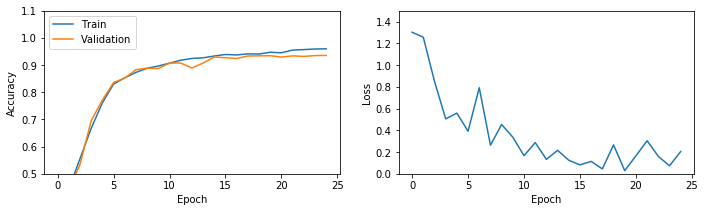

In [13]:
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.5,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(132)
plt.plot(history.history['val_loss'])
plt.ylim([0,1.5])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [14]:
from keras.models import load_model

modelFile = 'my_CNN.h5'

# model_path = os.path.abspath(os.curdir)
# file_path = os.path.join(model_path, modelFile)
my_model.save(modelFile)

In [15]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\zceecyt-AMLSassignment19_20-16053203\\notebook\\B1'

In [ ]:
df2 = pd.read_csv('../../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[2]])
df2['eye_color'] = df2['eye_color'].apply(str)
df2

In [ ]:
img = ('../../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [16]:
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "face_shape",
#         batch_size=1,
#         class_mode='categorical', target_size=(30, 30),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "eye_color",
        batch_size=1,
        class_mode='categorical', target_size=(30, 30),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 2000 validated image filenames belonging to 5 classes.
2000


In [17]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct gender
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# # format file names to simply male or female
# filenames=test_generator.filenames
# filenz=[0]
# for i in range(0,len(filenames)):
#     filenz.append(filenames[i].split('\\')[0])
# filenz=filenz[1:]

# # determine the test set accuracy
# match=[]
# for i in range(0,len(filenames)):
#     match.append(filenz[i]==predictions[i])
# match.count(True)/1000



2000/2000 [==============================] - 23s 12ms/step


In [18]:
import sklearn.metrics as metrics

Classification report
[[330  54   3   6   5]
 [  8 399   4  12   5]
 [  0   0 380   1   0]
 [  0  13   2 376   6]
 [  1   5   3   7 380]]
Confusion Matrix


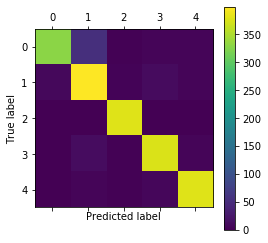

In [19]:
#confusion matrix and classification report

#Y_pred = my_model.predict_generator(test_generator, test_generator.samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)


#target_names = ['0','1','2','3','4']
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))

cm = confusion_matrix(test_generator.classes,predicted_class_indices)

print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Confusion Matrix')
plt.show()
print('Classification report')

In [20]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2344.4470040798187 seconds ---
